# Итоговый проект

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("default")

In [3]:
matplotlib.rcParams.update({'font.size': 14})
pd.options.display.max_columns = 100

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Загрузка данных

**Описание датасета:**
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
TRAIN_DATASET_PATH = 'datasets/train.csv'
TEST_DATASET_PATH = 'datasets/test.csv'

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


#### Проверка соответствия данных тренировочной и тестовой выборок и приведение типов

In [9]:
train_df.shape[1]-1 == test_df.shape[1]

True

In [10]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
def df_fix_id_type(df):
    train_df['Id'] = train_df['Id'].astype(str)
    return df

In [12]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### Обзор данных

#### Анализ поведения целевой переменной тренировочной выборки

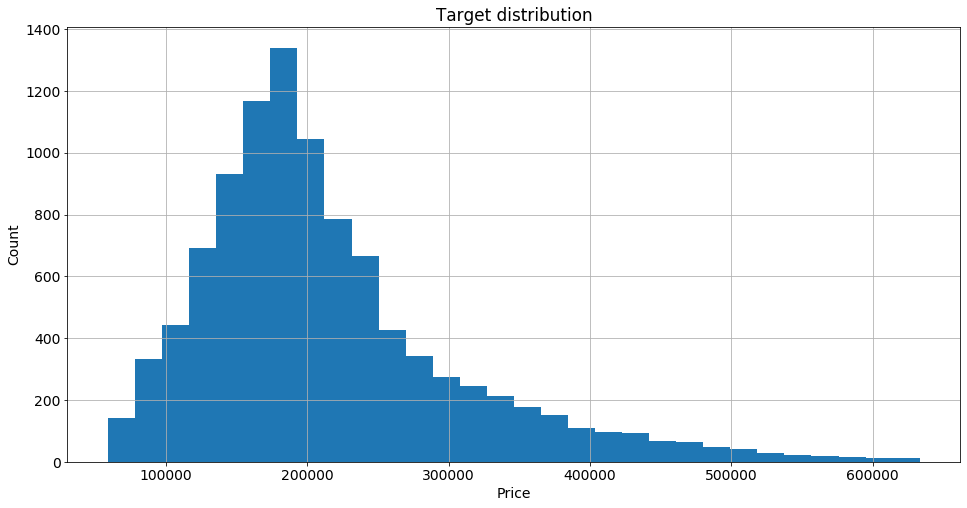

In [13]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

#### Анализ количетсвенных переменных тренировочной выборки

In [14]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Подозрительные значения переменных: 

минимальные значения:
* **LifeSquare** - минимальное значение меньше квадратного метра
* **Square**  - минимальное значение меньше двух квадратных метров
* **Rooms**  - минимальное количетсво комнат 0
* **HouseFloor** - не бывает домов с количеством этажей меньше 1


максимальные значения:
* **LifeSquare** - максимальное значение больше максимального значения переменной **Square**
* **KitchenSquare** - максимальное значение больше максимального значения переменной **Square**
* **HouseFloor** - В Лос-Анджелесе нет жилых домов выше 80 этажей
* **Social_2**  - слышком большое различие между средним и максимальным значением
* **Social_3** - слышком большое различие между средним и максимальным значением
* **HouseYear**
* **Rooms**
количесвтво недостающих данных:
* **LifeSquare**
* **Healthcare_1**

#### Анализ номинативных переменных тренировочной выборки

In [16]:
train_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [17]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [18]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [19]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

#### Rooms

In [20]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [21]:
def df_fix_rooms(df):
    df.loc[df['Rooms'].isin([0, 19]), 'Rooms'] = df['Rooms'].median()
    return df

**Square**, **LifeSquare**, **KitchenSquare**

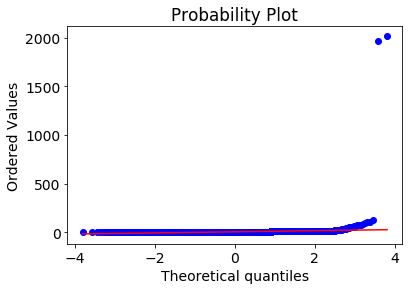

In [22]:
fig = plt.figure()
res = stats.probplot(train_df['KitchenSquare'], plot=plt)
plt.show()

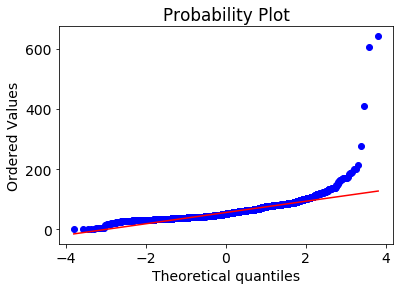

In [24]:
fig = plt.figure()
res = stats.probplot(train_df['Square'], plot=plt)
plt.show()

In [25]:
def df_fix_square(df):
    df.loc[df['Square'] > 250, 'Square'] = df.loc[df['Square'] > 250, 'Square'] / 10
    return df

In [26]:
def df_fix_kitchenSquare(df):
    df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
    df.loc[df['KitchenSquare'] > 150, 'KitchenSquare'] = df.loc[df['KitchenSquare'] > 150, 'KitchenSquare'] / 10
    return df

In [29]:
def df_prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'],
           'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
    return df


def df_fill_lifesquare(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
    return df

**Healthcare_1**

In [36]:
train_df['Healthcare_1'].value_counts()

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

In [30]:
def df_fix_healthcare_1(df):
    df.loc[df['Healthcare_1'] == 0, 'Healthcare_1'] = df['Healthcare_1'].median()
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    return df

**HouseFloor**, **Floor**

In [32]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [33]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [34]:
def df_fix_housefloor_floor(df):
    df.loc[df['HouseFloor'].isin([0, 99, 117]), 'HouseFloor'] = df['HouseFloor'].median()
    floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
    df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
    return df

**HouseYear**

In [35]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
1499        2020
5701        2020
7076        2020
          ...   
7611        1916
910         1914
5111        1912
2656        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [37]:
def df_fix_houseyear(df):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
    return df

**Social_2**, **Social_3**

In [38]:
train_df['Social_2'].value_counts()

264     587
1564    511
629     486
1437    346
6398    245
       ... 
568       3
1423      3
662       2
507       1
528       1
Name: Social_2, Length: 142, dtype: int64

In [39]:
train_df['Social_3'].value_counts()

0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
59       25
93       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: Social_3, dtype: int64

Более подробный анализ выявил отсутствие явных выбросов в переменных **Social_2** и **Social_3**

#### Приведение номинативных переменных к численному значению

In [40]:
def df_fix_nominal_features(df):
    df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
    df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
    df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})
    return df

#### Добавление новых признаков

In [41]:
def df_add_new_features(df):
    district_size = df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    df = df.merge(district_size, on='DistrictId', how='left')
    df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)
    return df

In [42]:
def df_add_mean_price(df, df_train=train_df):
    price = df_train['Price'].mean()
    price_mean_by_rooms = df_train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_by_rooms'})

    price_mean_by_distr_rooms = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_dr'})

    df = pd.merge(df, price_mean_by_distr_rooms, on=[
                  'DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_by_rooms'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price)
    df['mean_price_by_rooms'] = df['mean_price_by_rooms'].fillna(price)
    return df

#### Функция обработки данных

In [44]:
def data_prepare(df, df_train = train_df):
    df = df_fix_id_type(df)
    df = df_fix_rooms(df)
    df = df_fix_square(df)
    df = df_fix_kitchenSquare(df)
    df = df_prepare_lifesquare(df)
    df = df_fill_lifesquare(df)
    df = df_fix_healthcare_1(df)
    df = df_fix_housefloor_floor(df)
    df = df_fix_houseyear(df)
    df = df_fix_nominal_features(df)
    df = df_add_new_features(df)
    df = df_add_mean_price(df, df_train)
    return df

In [45]:
train_df = data_prepare(train_df)

### Проверка обработанных данных, обучение и тесты неросети

In [46]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'mean_price_dr',
 'mean_price_by_rooms']

In [47]:
features = list(train_df.loc[:, train_df.columns != 'Id'].corrwith(
    train_df['Price']).abs().sort_values(ascending=False)[1:].index)

target = 'Price'

In [48]:
train_df[features].head()

,mean_price_dr,Square,mean_price_by_rooms,Rooms,DistrictSize,LifeSquare,IsDistrictLarge,DistrictId,Social_1,Helthcare_2,Social_2,KitchenSquare,Shops_1,Healthcare_1,Floor,HouseFloor,Social_3,Shops_2_bin,Ecology_1,Ecology_3_bin,HouseYear,Ecology_2_bin
0,213160.076297,47.981561,215190.619851,2.0,22,29.442751,0,35,33,0,7976,6.0,11,900.0,7,9.0,5,1,0.089040,1,1969,1
1,303643.563728,65.683640,289337.962452,3.0,87,40.049543,0,41,46,1,10309,8.0,16,240.0,7,9.0,1,1,0.000070,1,1978,1
2,259938.729121,44.947953,215190.619851,2.0,174,29.197612,1,53,34,1,7759,3.0,3,229.0,8,12.0,0,1,0.049637,1,1968,1
3,172368.882269,53.352981,215190.619851,2.0,179,52.731512,1,58,23,0,5735,9.0,5,1084.0,8,17.0,3,1,0.437885,1,1977,1
4,155748.415754,39.649192,159850.800729,1.0,97,23.776169,0,99,35,2,5776,7.0,4,2078.0,11,12.0,1,1,0.012339,1,1976,1


In [49]:
X = train_df[features]
y = train_df[target]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9185 to 5327
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_price_dr        7000 non-null   float64
 1   Square               7000 non-null   float64
 2   mean_price_by_rooms  7000 non-null   float64
 3   Rooms                7000 non-null   float64
 4   DistrictSize         7000 non-null   int64  
 5   LifeSquare           7000 non-null   float64
 6   IsDistrictLarge      7000 non-null   int32  
 7   DistrictId           7000 non-null   int64  
 8   Social_1             7000 non-null   int64  
 9   Helthcare_2          7000 non-null   int64  
 10  Social_2             7000 non-null   int64  
 11  KitchenSquare        7000 non-null   float64
 12  Shops_1              7000 non-null   int64  
 13  Healthcare_1         7000 non-null   float64
 14  Floor                7000 non-null   int64  
 15  HouseFloor           7000 non-null 

In [52]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 3644 to 6890
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_price_dr        3000 non-null   float64
 1   Square               3000 non-null   float64
 2   mean_price_by_rooms  3000 non-null   float64
 3   Rooms                3000 non-null   float64
 4   DistrictSize         3000 non-null   int64  
 5   LifeSquare           3000 non-null   float64
 6   IsDistrictLarge      3000 non-null   int32  
 7   DistrictId           3000 non-null   int64  
 8   Social_1             3000 non-null   int64  
 9   Helthcare_2          3000 non-null   int64  
 10  Social_2             3000 non-null   int64  
 11  KitchenSquare        3000 non-null   float64
 12  Shops_1              3000 non-null   int64  
 13  Healthcare_1         3000 non-null   float64
 14  Floor                3000 non-null   int64  
 15  HouseFloor           3000 non-null 

In [53]:
rf_model = RandomForestRegressor(n_estimators = 10, random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

Train R2:	0.953
Test R2:	0.727


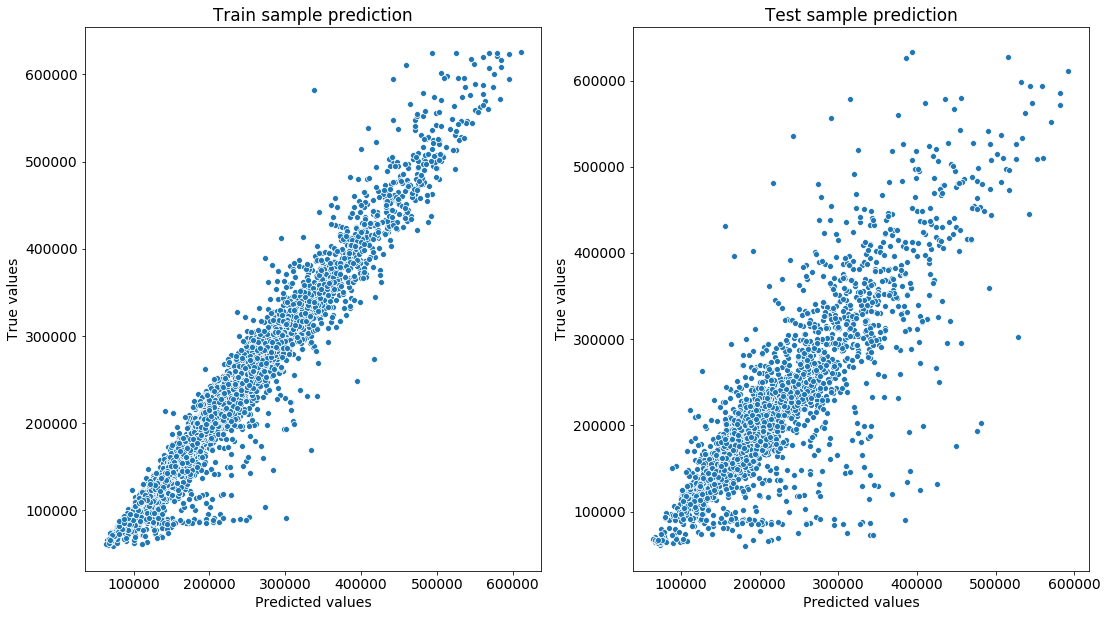

In [54]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Предсказание Price на тестовом датасете

In [55]:
test_df = data_prepare(test_df)

In [56]:
test_features = list(X_train.columns)

In [57]:
test_df[test_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mean_price_dr        5000 non-null   float64
 1   Square               5000 non-null   float64
 2   mean_price_by_rooms  5000 non-null   float64
 3   Rooms                5000 non-null   float64
 4   DistrictSize         5000 non-null   int64  
 5   LifeSquare           5000 non-null   float64
 6   IsDistrictLarge      5000 non-null   int32  
 7   DistrictId           5000 non-null   int64  
 8   Social_1             5000 non-null   int64  
 9   Helthcare_2          5000 non-null   int64  
 10  Social_2             5000 non-null   int64  
 11  KitchenSquare        5000 non-null   float64
 12  Shops_1              5000 non-null   int64  
 13  Healthcare_1         5000 non-null   float64
 14  Floor                5000 non-null   int64  
 15  HouseFloor           5000 non-null   f

In [58]:
test_df['Price'] = rf_model.predict(test_df[test_features])

In [59]:
test_df[['Id', 'Price']].to_csv('GBashkirov_predictions.csv', index=None)